TODO : 
- voir traitement de text sur nlp
- Commencer la partie texte et avec quelques reviews pour le nettoyage (bag of word)

NOTE : 
- Pas sur d'avoir besoin du bago of word avec le tf-idf

# Analyse des textes

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import math

from collections import Counter
import re
import math

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.cluster import KMeansClusterer
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

from sklearn import cluster
from sklearn import metrics

[nltk_data] Downloading package wordnet to /home/reda/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/reda/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /home/reda/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/reda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df_review = pd.read_csv('data/yelp_dataset/csv/df_review.csv')
df_tip = pd.read_csv('data/yelp_dataset/csv/df_tip.csv')
df_user = pd.read_csv('data/yelp_dataset/csv/df_user.csv')
df_business = pd.read_csv('data/yelp_dataset/csv/df_business.csv')
df_checkin = pd.read_csv('data/yelp_dataset/csv/df_checkin.csv')

## Analyse exploratoire des textes

Pour notre analyse exploratoires des textes, nous allons commencer par un deux commentaires.

In [3]:
premier_commentaire = df_review['text'][0]
deuxieme_commentaire = df_review['text'][1]

In [4]:
# Coupe le texte par mot et ponctuation
print(nltk.word_tokenize(premier_commentaire))
print("\n")
print(nltk.word_tokenize(deuxieme_commentaire))

['If', 'you', 'decide', 'to', 'eat', 'here', ',', 'just', 'be', 'aware', 'it', 'is', 'going', 'to', 'take', 'about', '2', 'hours', 'from', 'beginning', 'to', 'end', '.', 'We', 'have', 'tried', 'it', 'multiple', 'times', ',', 'because', 'I', 'want', 'to', 'like', 'it', '!', 'I', 'have', 'been', 'to', 'it', "'s", 'other', 'locations', 'in', 'NJ', 'and', 'never', 'had', 'a', 'bad', 'experience', '.', 'The', 'food', 'is', 'good', ',', 'but', 'it', 'takes', 'a', 'very', 'long', 'time', 'to', 'come', 'out', '.', 'The', 'waitstaff', 'is', 'very', 'young', ',', 'but', 'usually', 'pleasant', '.', 'We', 'have', 'just', 'had', 'too', 'many', 'experiences', 'where', 'we', 'spent', 'way', 'too', 'long', 'waiting', '.', 'We', 'usually', 'opt', 'for', 'another', 'diner', 'or', 'restaurant', 'on', 'the', 'weekends', ',', 'in', 'order', 'to', 'be', 'done', 'quicker', '.']


['I', "'ve", 'taken', 'a', 'lot', 'of', 'spin', 'classes', 'over', 'the', 'years', ',', 'and', 'nothing', 'compares', 'to', 'the',

Nous n'avons pas besoin de ponctuation, de chiffre, et nous ne devons pas différencier les mots avec une majuscule et les mots sans, car ils signifient la même chose.

Nous allons donc normaliser nos textes tokenisés.

### Normalisation du texte

In [5]:
def nettoyage_texte(texte):
    # regex r'[a-zA-Z]{1,}' : ne garde que les mots (pas de valeurs numériques)
    tokenizer = nltk.RegexpTokenizer(r'[a-zA-Z]{1,}')
    texte = tokenizer.tokenize(texte)

    # Passe toutes les majuscules en minuscules
    texte = (map(lambda x: x.lower(), texte))
    texte = list(texte)
    print(texte)
    
    return texte

In [6]:
premier_commentaire = nettoyage_texte(premier_commentaire)
print('\n')
deuxieme_commentaire = nettoyage_texte(deuxieme_commentaire)

['if', 'you', 'decide', 'to', 'eat', 'here', 'just', 'be', 'aware', 'it', 'is', 'going', 'to', 'take', 'about', 'hours', 'from', 'beginning', 'to', 'end', 'we', 'have', 'tried', 'it', 'multiple', 'times', 'because', 'i', 'want', 'to', 'like', 'it', 'i', 'have', 'been', 'to', 'it', 's', 'other', 'locations', 'in', 'nj', 'and', 'never', 'had', 'a', 'bad', 'experience', 'the', 'food', 'is', 'good', 'but', 'it', 'takes', 'a', 'very', 'long', 'time', 'to', 'come', 'out', 'the', 'waitstaff', 'is', 'very', 'young', 'but', 'usually', 'pleasant', 'we', 'have', 'just', 'had', 'too', 'many', 'experiences', 'where', 'we', 'spent', 'way', 'too', 'long', 'waiting', 'we', 'usually', 'opt', 'for', 'another', 'diner', 'or', 'restaurant', 'on', 'the', 'weekends', 'in', 'order', 'to', 'be', 'done', 'quicker']


['i', 've', 'taken', 'a', 'lot', 'of', 'spin', 'classes', 'over', 'the', 'years', 'and', 'nothing', 'compares', 'to', 'the', 'classes', 'at', 'body', 'cycle', 'from', 'the', 'nice', 'clean', 'spac

Voyons maintenant la fréquence des mots de ces deux avis.

In [7]:
def frequence_mot(liste):
    count = Counter(liste)
    df = pd.DataFrame.from_dict(count, orient='index')
    df.plot(figsize=(15,7), kind='bar')

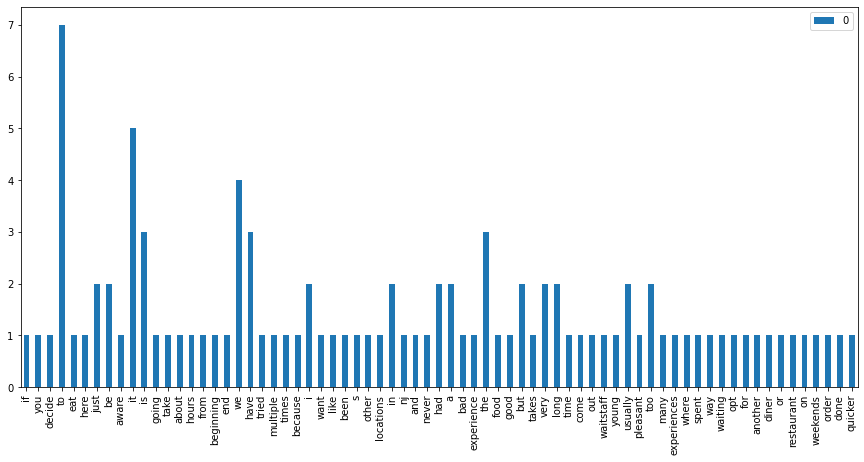

In [8]:
frequence_mot(premier_commentaire)

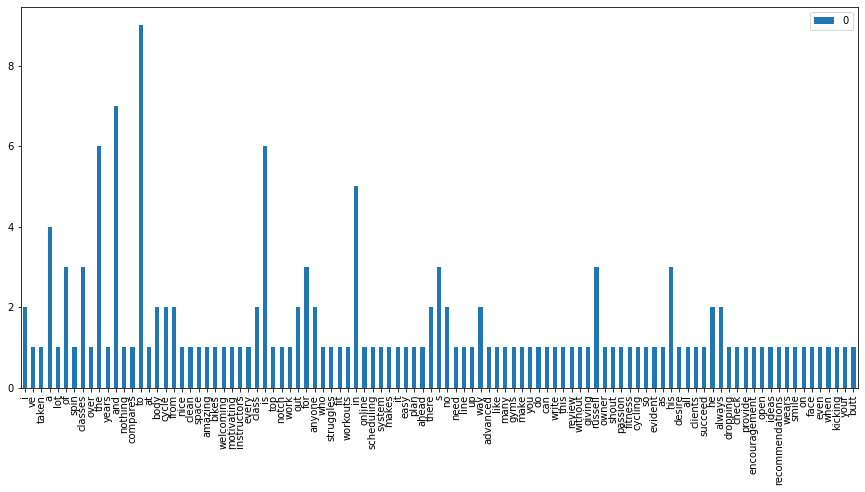

In [9]:
frequence_mot(deuxieme_commentaire)

### Stop word

Nous devons maintenant supprimer tous les mots inutiles appelé "stopword" tel que les determinants etc.

In [10]:
# Les 100 mots les plus fréquents par défaut présent dans la 
# librairie NLTK
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

On supprime ensuite les stopword présent dans nos deux commentaires à partir de la liste des stopword de la librairie ntlk. 

In [11]:
def supprimer_stopwords(texte):
    for stopword in stopwords.words('english'):
        for word in texte:
            if stopword == word:
                texte.remove(stopword)

    return texte

In [12]:
supprimer_stopwords(premier_commentaire)

['decide',
 'eat',
 'aware',
 'going',
 'take',
 'hours',
 'beginning',
 'end',
 'tried',
 'multiple',
 'times',
 'want',
 'like',
 'locations',
 'nj',
 'never',
 'bad',
 'experience',
 'food',
 'good',
 'takes',
 'long',
 'time',
 'come',
 'waitstaff',
 'young',
 'usually',
 'pleasant',
 'many',
 'experiences',
 'spent',
 'way',
 'long',
 'waiting',
 'usually',
 'opt',
 'another',
 'diner',
 'restaurant',
 'weekends',
 'order',
 'done',
 'quicker']

In [13]:
supprimer_stopwords(deuxieme_commentaire)

['taken',
 'lot',
 'spin',
 'classes',
 'years',
 'nothing',
 'compares',
 'classes',
 'body',
 'cycle',
 'nice',
 'clean',
 'space',
 'amazing',
 'bikes',
 'welcoming',
 'motivating',
 'instructors',
 'every',
 'class',
 'top',
 'notch',
 'work',
 'anyone',
 'struggles',
 'fit',
 'workouts',
 'online',
 'scheduling',
 'system',
 'makes',
 'easy',
 'plan',
 'ahead',
 'need',
 'line',
 'way',
 'advanced',
 'like',
 'many',
 'gyms',
 'make',
 'way',
 'write',
 'review',
 'without',
 'giving',
 'russell',
 'owner',
 'body',
 'cycle',
 'shout',
 'russell',
 'passion',
 'fitness',
 'cycling',
 'evident',
 'desire',
 'clients',
 'succeed',
 'always',
 'dropping',
 'classes',
 'check',
 'provide',
 'encouragement',
 'open',
 'ideas',
 'recommendations',
 'anyone',
 'russell',
 'always',
 'wears',
 'smile',
 'face',
 'even',
 'kicking',
 'butt',
 'class']

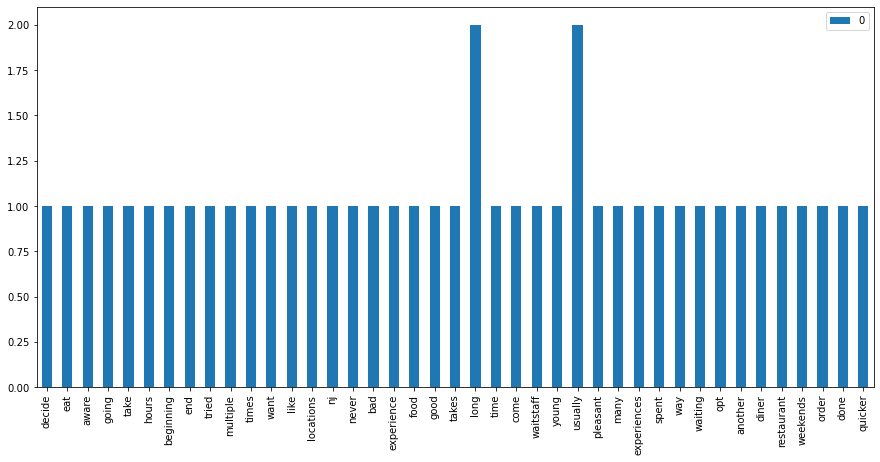

In [14]:
frequence_mot(premier_commentaire)

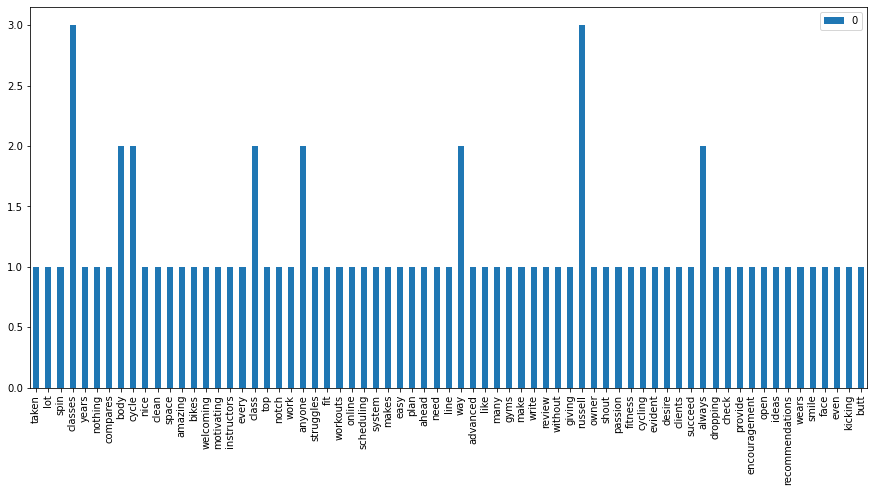

In [15]:
frequence_mot(deuxieme_commentaire)

Nous devons aussi créer nos propres stopwrods. En effet, il suffit de récupérer les mots les plus présent dans nos textes, il est en effet peu probable que ces mots soient porteur de sens.

In [16]:
def stopwords_perso(texte):
    dict_count_texte = Counter(texte)
    dict_test = dict(
        reversed(
            sorted(dict_count_texte.items(),
                   key=lambda item: item[1])))

    dict_100_premier_mots = {k: dict_test[k] for k in list(dict_test)[:100]}
    liste_stopword = dict_100_premier_mots.keys()
    return liste_stopword

In [17]:
commentaire_combinés = premier_commentaire + deuxieme_commentaire
nos_stopwords = stopwords_perso(commentaire_combinés)
nos_stopwords

dict_keys(['russell', 'classes', 'way', 'always', 'anyone', 'class', 'cycle', 'body', 'many', 'usually', 'long', 'like', 'butt', 'kicking', 'even', 'face', 'smile', 'wears', 'recommendations', 'ideas', 'open', 'encouragement', 'provide', 'check', 'dropping', 'succeed', 'clients', 'desire', 'evident', 'cycling', 'fitness', 'passion', 'shout', 'owner', 'giving', 'without', 'review', 'write', 'make', 'gyms', 'advanced', 'line', 'need', 'ahead', 'plan', 'easy', 'makes', 'system', 'scheduling', 'online', 'workouts', 'fit', 'struggles', 'work', 'notch', 'top', 'every', 'instructors', 'motivating', 'welcoming', 'bikes', 'amazing', 'space', 'clean', 'nice', 'compares', 'nothing', 'years', 'spin', 'lot', 'taken', 'quicker', 'done', 'order', 'weekends', 'restaurant', 'diner', 'another', 'opt', 'waiting', 'spent', 'experiences', 'pleasant', 'young', 'waitstaff', 'come', 'time', 'takes', 'good', 'food', 'experience', 'bad', 'never', 'nj', 'locations', 'want', 'times', 'multiple', 'tried', 'end'])

Nous utilisons que deux commentaires pour le moment, il est donc normal de ne pas avoir un résultat fiable.

Nos propres stopword ne seront pertinent que lorsque que nous procéderons avec beaucoup plus de commentaire.

TODO : AJOUTER UNE CELLULE POUR LA SUPPRESSION 100 MOTS LES PLUS UTILISES QUAND + DE TEXTES SERA UTILISE

### Lemmatisation

Le processus de **« lemmatisation »** consiste à représenter les mots sous leur forme **canonique**. 
Par exemple pour un **verbe, ce sera son infinitif**. Pour un nom, son masculin singulier. 

L'idée étant encore une fois de ne conserver que le sens des mots.

In [18]:
def lemmatisation(liste):
    lemmatizer = WordNetLemmatizer()

    texte = []

    # Parcour la liste pour lemmatiser chaque mot
    for mot in liste:
        texte.append(lemmatizer.lemmatize(mot))

    return texte

In [19]:
lemmatisation(premier_commentaire)
lemmatisation(deuxieme_commentaire)

['taken',
 'lot',
 'spin',
 'class',
 'year',
 'nothing',
 'compare',
 'class',
 'body',
 'cycle',
 'nice',
 'clean',
 'space',
 'amazing',
 'bike',
 'welcoming',
 'motivating',
 'instructor',
 'every',
 'class',
 'top',
 'notch',
 'work',
 'anyone',
 'struggle',
 'fit',
 'workout',
 'online',
 'scheduling',
 'system',
 'make',
 'easy',
 'plan',
 'ahead',
 'need',
 'line',
 'way',
 'advanced',
 'like',
 'many',
 'gym',
 'make',
 'way',
 'write',
 'review',
 'without',
 'giving',
 'russell',
 'owner',
 'body',
 'cycle',
 'shout',
 'russell',
 'passion',
 'fitness',
 'cycling',
 'evident',
 'desire',
 'client',
 'succeed',
 'always',
 'dropping',
 'class',
 'check',
 'provide',
 'encouragement',
 'open',
 'idea',
 'recommendation',
 'anyone',
 'russell',
 'always',
 'wear',
 'smile',
 'face',
 'even',
 'kicking',
 'butt',
 'class']

In [20]:
# Compare les deux listes de chaque commentaire
premier_commentaire_lemm = lemmatisation(premier_commentaire)
print("Voici les mots qui ont été lemmatisés :\n")
print(list(set(premier_commentaire) - set(premier_commentaire_lemm)))

print('\n')

deuxieme_commentaire_lemm = lemmatisation(deuxieme_commentaire)
print("Voici les mots qui ont été lemmatisés :\n")
print(list(set(deuxieme_commentaire) - set(deuxieme_commentaire_lemm)))

Voici les mots qui ont été lemmatisés :

['times', 'experiences', 'takes', 'locations', 'hours', 'weekends']


Voici les mots qui ont été lemmatisés :

['recommendations', 'ideas', 'classes', 'clients', 'bikes', 'workouts', 'years', 'instructors', 'gyms', 'wears', 'makes', 'compares', 'struggles']


Nous avons donc lemmatiser nos deux commentaires.

### Racinisation (stemming)

Cela consiste à ne conserver que la racine des mots étudiés. L'idée étant de supprimer les suffixes, préfixes et autres des mots afin de ne conserver que leur origine.

In [21]:
def racinisation(liste):
    stemmer = SnowballStemmer("english")

    texte = []

    # Parcour la liste pour lemmatiser chaque mot
    for mot in liste:
        texte.append(stemmer.stem(mot))

    return texte

In [22]:
racinisation(premier_commentaire_lemm)
racinisation(deuxieme_commentaire_lemm)

['taken',
 'lot',
 'spin',
 'class',
 'year',
 'noth',
 'compar',
 'class',
 'bodi',
 'cycl',
 'nice',
 'clean',
 'space',
 'amaz',
 'bike',
 'welcom',
 'motiv',
 'instructor',
 'everi',
 'class',
 'top',
 'notch',
 'work',
 'anyon',
 'struggl',
 'fit',
 'workout',
 'onlin',
 'schedul',
 'system',
 'make',
 'easi',
 'plan',
 'ahead',
 'need',
 'line',
 'way',
 'advanc',
 'like',
 'mani',
 'gym',
 'make',
 'way',
 'write',
 'review',
 'without',
 'give',
 'russel',
 'owner',
 'bodi',
 'cycl',
 'shout',
 'russel',
 'passion',
 'fit',
 'cycl',
 'evid',
 'desir',
 'client',
 'succeed',
 'alway',
 'drop',
 'class',
 'check',
 'provid',
 'encourag',
 'open',
 'idea',
 'recommend',
 'anyon',
 'russel',
 'alway',
 'wear',
 'smile',
 'face',
 'even',
 'kick',
 'butt',
 'class']

In [23]:
# Compare les deux listes de chaque commentaire
premier_commentaire_racinisation = racinisation(premier_commentaire_lemm)
print("Voici les mots qui ont été stemming :\n")
print(list(set(premier_commentaire_racinisation) - set(premier_commentaire_lemm)))

print('\n')

deuxieme_commentaire_racinisation = racinisation(deuxieme_commentaire_lemm)
print("Voici les mots qui ont été stemming :\n")
print(list(set(deuxieme_commentaire_racinisation) - set(deuxieme_commentaire_lemm)))

Voici les mots qui ont été stemming :

['awar', 'begin', 'anoth', 'restaur', 'go', 'locat', 'wait', 'mani', 'usual', 'decid', 'multipl', 'experi', 'tri']


Voici les mots qui ont été stemming :

['evid', 'alway', 'cycl', 'provid', 'compar', 'recommend', 'desir', 'give', 'motiv', 'encourag', 'easi', 'onlin', 'russel', 'kick', 'anyon', 'welcom', 'noth', 'schedul', 'amaz', 'bodi', 'advanc', 'drop', 'struggl', 'mani', 'everi']


En effet, la racinisation a supprimé les suffixes, préfixes, etc.

Par exemple le mot **"location" (localisation)** est devenu **"locat" (localiser)**, le mot **"experience" (experience)** est devenu **"experi" (experimenter)**.

Nous devons donc faire attention à ne pas changer le sens des mots.

Nous utiliserons donc la lemmatisation plutôt que la racinisation.

## Bag of Words

Le principe du **bag of word** est de considéré chaque texte, ici chaque commentaire, par la représentation brute d'un "sac" de tous les mots présent dans le commentaire, sans soucis de contexte (ordre, utilisation, etc).

La première chose à considérer, au delà d'une tokenisation, c'est qu'il est possible de séparer le texte en groupes de plusieurs mots. 
On appelle les groupes de mots les **n-grammes (n-gram)** : **bigrammes pour les couples de mots**, **trigrammes pour les groupes de 3**, etc. Séparer en mot unique est en fait un cas particulier appelé **unigrammes**.

Par exemple dans la phrase : « Je mange une pomme », on peut extraire les bigrammes {(je, mange), (mange, une) et (une, pomme)}

Lorsqu'on fait fasse à une problématique de modélisation du langage, on voit bien que pour étudier idéalement le sens d'un mot il faudrait l'observer dans son contexte. Il existe donc dans un texte (et par extension dans le langage) une forme de dépendance plus ou moins grande entre les mots.

Par exemple on peut assigner une probabilité au bigramme ("je", "mange") :

In [24]:
def bigrams(texte):
    tokenizer = nltk.RegexpTokenizer(r'[a-zA-Z]{1,}')
    # Concatène les mots de la liste de mots en ajoutant un espace entre
    # chaque mot
    words_list = " ".join(texte)
    
    token = tokenizer.tokenize(words_list)
    liste_bigram = list(nltk.bigrams(token))

    return liste_bigram

In [25]:
print(bigrams(premier_commentaire_lemm))
print(bigrams(deuxieme_commentaire_lemm))

[('decide', 'eat'), ('eat', 'aware'), ('aware', 'going'), ('going', 'take'), ('take', 'hour'), ('hour', 'beginning'), ('beginning', 'end'), ('end', 'tried'), ('tried', 'multiple'), ('multiple', 'time'), ('time', 'want'), ('want', 'like'), ('like', 'location'), ('location', 'nj'), ('nj', 'never'), ('never', 'bad'), ('bad', 'experience'), ('experience', 'food'), ('food', 'good'), ('good', 'take'), ('take', 'long'), ('long', 'time'), ('time', 'come'), ('come', 'waitstaff'), ('waitstaff', 'young'), ('young', 'usually'), ('usually', 'pleasant'), ('pleasant', 'many'), ('many', 'experience'), ('experience', 'spent'), ('spent', 'way'), ('way', 'long'), ('long', 'waiting'), ('waiting', 'usually'), ('usually', 'opt'), ('opt', 'another'), ('another', 'diner'), ('diner', 'restaurant'), ('restaurant', 'weekend'), ('weekend', 'order'), ('order', 'done'), ('done', 'quicker')]
[('taken', 'lot'), ('lot', 'spin'), ('spin', 'class'), ('class', 'year'), ('year', 'nothing'), ('nothing', 'compare'), ('compa

## TF-IDF |Term-Frequency - Inverse Document Frequency

Nous avons d'abord supprimé les mots les plus fréquents de manière générale dans le langage (les fameux stopwords). À présent, il ne faut pas considérer le poids d'un mot dans un document comme sa fréquence d'apparition uniquement, mais pondérer cette fréquence par un indicateur **si ce mot est commun ou rare** dans tous les documents.

Depuis le départ, on a seulement utilisé les fréquences d'apparition des différents mots/n-grammes présents dans notre corpus. Le problème est que si l'on veut vraiment représenter un document par les n-grammes qu'il contient, il faudrait le faire relativement à leur apparition dans les autres documents.

En effet, si un mot apparait dans d'autres documents, il est donc moins représentatif du document qu'un mot qui n'apparait que uniquement dans ce document.

**fréquence de terme TF** = (nombre de mot dans un texte / nombre total de mots)

**fréquence de document inverse IDF** = log(nombre total de textes / nombre total de textes avec le mot)

### TF

In [26]:
def tf(liste):
    # nombre de mot dans la liste
    nb_de_mot = len(liste)
    # Fréquence de chaque mot dans la liste
    count = Counter(liste)
    # Place les mots et leurs fréquence dans une dataframe
    df = pd.DataFrame.from_dict(count, orient='index')
    # Divise la fréquence de chaque mot par le nombre total de mot présent
    # dans la liste
    df_tf = df / nb_de_mot
    return df_tf

In [27]:
premier_commentaire_tf = tf(premier_commentaire_lemm)
premier_commentaire_tf.rename(columns = {0:'TF'}, inplace = True)
print(premier_commentaire_tf.head(5))

print('\n')

deuxieme_commentaire_tf = tf(deuxieme_commentaire_lemm)
deuxieme_commentaire_tf.rename(columns = {0:'TF'}, inplace = True)
print(deuxieme_commentaire_tf.head(5))

              TF
decide  0.023256
eat     0.023256
aware   0.023256
going   0.023256
take    0.046512


             TF
taken  0.012658
lot    0.012658
spin   0.012658
class  0.063291
year   0.012658


Nous devons maintenant obtenir la fréquence d'un mot mais cette fois-ci, présent dans chacun des textes.

### IDF

In [28]:
# Cette fonction permet d'obtenir une dataframe regroupant la fréquence
# de chaque mot pour chacun des texte.
def frequence_idf(liste_texte):
    """

    Un minimum de 2 textes dans la liste est nécessaire 
    pour que la fonction fonctionne
    

    """
    # Nombre de texte présent dans la liste
    nb_texte = len(liste_texte)
    # Nous créons le dictionnaire 'dict_fusion' qui va contenir la fusion de
    # nos deux premiers textes counterizés pour ensuite le fusionner avec
    # le texte suivant
    dict_fusion = Counter(liste_texte[0]) + Counter(liste_texte[1])
    # L'indice i va parcourir le nombre de texte pour pouvoir appeler le
    # texte par son emplacement dans la liste.
    # l'indice commencera par '2' puisque nous avons déjà utilisé les
    # deux premiers textes en créant le dictionnaire "dict_fusion"
    for i in range(2, nb_texte):
        try:
            dict_fusion = dict_fusion + Counter(liste_texte[i])
        # Nous laissons la boucle se terminer si une erreur "IndexError"
        # apparaît, car cela est dû au fait que l'indice i a atteint le
        # dernier texte de la liste.
        except (IndexError):
            continue

    # Nous plaçons ensuite notre dictionnaire 'dict_fusion' dans une dataframe
    df = pd.DataFrame.from_dict(dict_fusion, orient='index')
    return df

In [29]:
liste_des_textes = [premier_commentaire_lemm, deuxieme_commentaire_lemm]
df_frequence_idf = frequence_idf(liste_des_textes)
df_frequence_idf.rename(columns = {0:'frequence_total'}, inplace = True)
df_frequence_idf

,frequence_total
decide,1
eat,1
aware,1
going,1
take,2
...,...
smile,1
face,1
even,1
kicking,1


Très bien, nous avons maintenant la fréquence des mots dans chacuns des textes (commentaires).

Nous devons maintenant connaître le poids de chaque mot, selon wikipedia :

**Cette mesure statistique (idf) permet d'évaluer l'importance d'un terme contenu dans un document, relativement à une collection ou un corpus. Le poids augmente proportionnellement au nombre d'occurrences du mot dans le document.**

Nous devons donc utiliser le logarithme de la libraire **math, la fonction math.log()**.

TODO : Le log() est en base 10 (log decimal) à voir si c'est correct.

In [30]:
def logarithme(df, nb_textes):
    # Place dans la variable 'div' la division des valeurs de la variable
    # 'frequence_total' par le nombre total de documents
    df['div'] = nb_textes / df['frequence_total']
    # Place dans la variable 'log' le logarithme des valeurs de la variable 
    # 'div'
    df['log'] = np.log10(df['div'])
    return df

In [31]:
df_idf = logarithme(df_frequence_idf, 2)

In [32]:
df_idf

,frequence_total,div,log
decide,1,2.0,0.30103
eat,1,2.0,0.30103
aware,1,2.0,0.30103
going,1,2.0,0.30103
take,2,1.0,0.00000
...,...,...,...
smile,1,2.0,0.30103
face,1,2.0,0.30103
even,1,2.0,0.30103
kicking,1,2.0,0.30103


Nous avons maintenant notre dataframe composée de : 
 - La fréquence des mots dans chacun des commentaires
 - La division de leurs valeurs pas le nombre de commentaires
 - Le logarithme de leurs valeurs divisées

### TF-IDF

Nous avons maintenant besoin d'ajouter à nos commentaires le **TF-IDF** de chaque mot.

Nous allons donc reprendre nos commentaire séparément, leurs ajouter la variable **IDF** que nous récupèrons de la dataframe **df_idf**. Puis nous ajoutons une variable **TF-IDF** qui est la multiplication de la variable **TF** avec la variable **IDF**.

**TF-IDF = TF x IDF**

In [33]:
print(premier_commentaire_tf.head(10))
print(deuxieme_commentaire_tf.head(10))

                 TF
decide     0.023256
eat        0.023256
aware      0.023256
going      0.023256
take       0.046512
hour       0.023256
beginning  0.023256
end        0.023256
tried      0.023256
multiple   0.023256
               TF
taken    0.012658
lot      0.012658
spin     0.012658
class    0.063291
year     0.012658
nothing  0.012658
compare  0.012658
body     0.025316
cycle    0.025316
nice     0.012658


Nous allons placer les valeurs **TF** de chaque mot dans notre dataframe.

In [34]:
def tf_idf(dataframe):
    df = dataframe
    df['IDF'] = df_idf['log']
    df['TF-IDF'] = df['TF'] * df['IDF']
    return df

In [35]:
premier_commentaire_tfidf = tf_idf(premier_commentaire_tf)
deuxieme_commentaire_tfidf = tf_idf(deuxieme_commentaire_tf)

In [36]:
print(premier_commentaire_tfidf.head(10))
print('\n')
print(deuxieme_commentaire_tfidf.head(10))

                 TF      IDF    TF-IDF
decide     0.023256  0.30103  0.007001
eat        0.023256  0.30103  0.007001
aware      0.023256  0.30103  0.007001
going      0.023256  0.30103  0.007001
take       0.046512  0.00000  0.000000
hour       0.023256  0.30103  0.007001
beginning  0.023256  0.30103  0.007001
end        0.023256  0.30103  0.007001
tried      0.023256  0.30103  0.007001
multiple   0.023256  0.30103  0.007001


               TF      IDF    TF-IDF
taken    0.012658  0.30103  0.003811
lot      0.012658  0.30103  0.003811
spin     0.012658  0.30103  0.003811
class    0.063291 -0.39794 -0.025186
year     0.012658  0.30103  0.003811
nothing  0.012658  0.30103  0.003811
compare  0.012658  0.30103  0.003811
body     0.025316  0.00000  0.000000
cycle    0.025316  0.00000  0.000000
nice     0.012658  0.30103  0.003811


**Plus un mot est rare, plus il a de la valeur.** Donc, plus la valeur de TF-IDF est élevé, plus le mot a de la valeur.

Nous avons maintenant la possibilité d'avoir pour chaque commentaire son :
- **TF**
- **IDF**
- Et **TF-IDF**

## Visualisation avec t-SNE (t-distributed Stochastic Neighbor Embedding)

L’algorithme **t-SNE** consiste à créer une distribution de probabilité qui représente les similarités entre voisins dans un espace en grande dimension et dans un espace de plus petite dimension.

TODO : Problème avec yellowbrick ?

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

from yellowbrick.text import TSNEVisualizer
from yellowbrick.datasets import load_hobbies

# Load the data and create document vectors
corpus = load_hobbies()
tfidf = TfidfVectorizer()

X = tfidf.fit_transform(corpus.data)
y = corpus.target

# Create the visualizer and draw the vectors
tsne = TSNEVisualizer()
tsne.fit(X, y)
tsne.show()

ImportError: cannot import name 'safe_indexing' from 'sklearn.utils' (/home/reda/anaconda3/envs/P6/lib/python3.7/site-packages/sklearn/utils/__init__.py)

In [38]:
from sklearn.utils import safe_indexing

ImportError: cannot import name 'safe_indexing' from 'sklearn.utils' (/home/reda/anaconda3/envs/P6/lib/python3.7/site-packages/sklearn/utils/__init__.py)